# Emotion Recognition with simple CNN

### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

2025-12-13 11:50:31.082750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


### Dataset loading

In [34]:
# Load dataset
from keras.preprocessing import image_dataset_from_directory

cwd: str = os.getcwd()

train_dir: str = os.path.join(cwd, "../data/train")
test_dir: str = os.path.join(cwd, "../data/test")

batch_size: int = 64
img_size: tuple = (48, 48)
seed: int = 42

# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"],
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Show one example image for each class from the training dataset

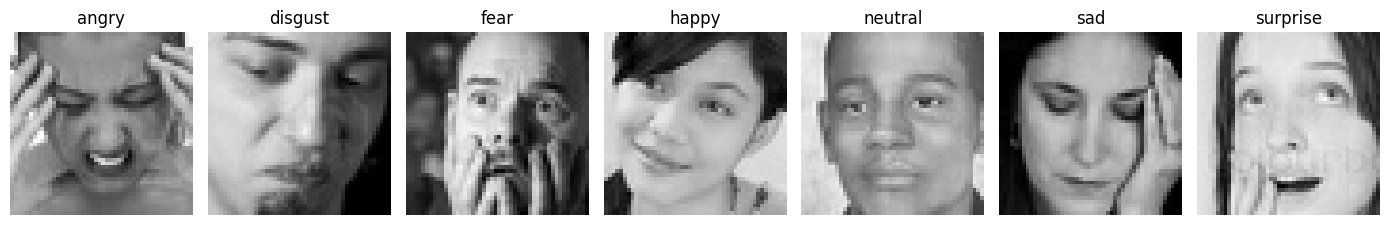

In [3]:
class_names: list[str] = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
num_classes: int = len(class_names)

sample_images: list[None] = [None] * num_classes

# Collect one image per class
for img, label in train_dataset.unbatch():
    class_idx = int(tf.argmax(label).numpy())
    if sample_images[class_idx] is None:
        sample_images[class_idx] = img.numpy()
    if all(im is not None for im in sample_images):
        break

# Plot
plt.figure(figsize=(14, 3))
for i, (img, cname) in enumerate(zip(sample_images, class_names)):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(cname)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
def plot_class_distribution(dataset_dir, subset_name):
    """Plot the class distribution of the dataset"""
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images

    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name)
    plt.show()

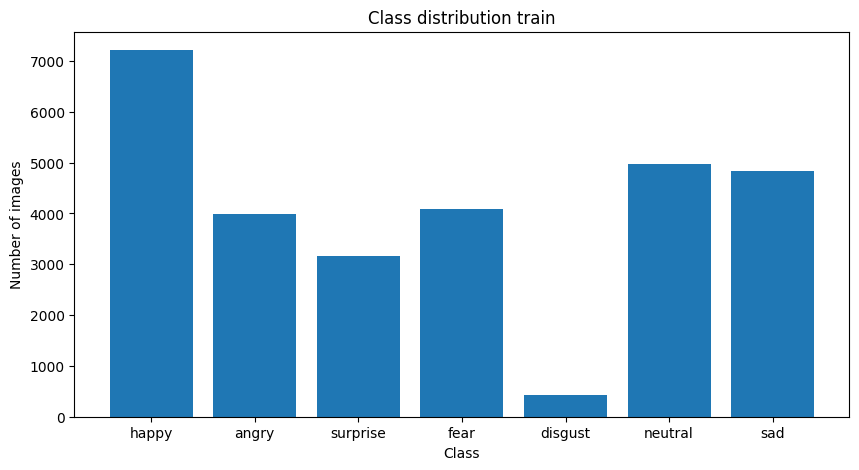

In [5]:
plot_class_distribution(train_dir, "train")

In [35]:
# Print class distribution
class_count = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_count[class_name] = num_images

print("Class Distribution:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Class Distribution:
happy: 7215
angry: 3995
surprise: 3171
fear: 4097
disgust: 436
neutral: 4965
sad: 4830


### Helper Classes and Functions

In [6]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create the data augmentation pipeline"""
        return keras.Sequential(
            [
                keras.layers.RandomFlip(
                    "horizontal_and_vertical"
                ),
                keras.layers.RandomRotation(0.1),
            ]
        )

    def preprocess_image(self, image, is_gray=True):
        """Convert image to grayscale float32 and normalize"""
        if is_gray:
            image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.float32)  # scales to [0, 1]
        return image

    def augment_and_preprocess(self, image, augment):
        """Apply data augmentation and preprocess the image"""
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image)

    def prepare_dataset(self, dataset, augment=False):
        """Prepare a single dataset split for training"""
        dataset = dataset.map(
            lambda x, y: (self.augment_and_preprocess(x, augment), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [7]:
def plot_history(history) -> None:
    """Function to plot the training and validation history"""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()


In [ ]:
def metrics(model, class_names, test_ds):
    """Function to calculate the metrics of the model"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")

    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    # Get the true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report

    print(classification_report(y_true, y_pred))

    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [43]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Dict, Any, Union, List


def generate_class_weights(
    class_series: Union[List[Any], np.ndarray],
    multi_class: bool = True,
    one_hot_encoded: bool = False,
) -> Dict[int, float]:
    """
    Generates Keras-compatible class weights.

    - Multi-class: returns weights usable with `class_weight`
    - Multi-label: returns per-class weights (must be converted to sample_weight)
    """

    # -----------------------
    # MULTI-CLASS
    # -----------------------
    if multi_class:
        if one_hot_encoded:
            y = np.argmax(class_series, axis=1)
        else:
            y = np.asarray(class_series)

        # Force integer labels for Keras
        classes, y_int = np.unique(y, return_inverse=True)

        weights = compute_class_weight(
            class_weight="balanced",
            classes=np.arange(len(classes)),
            y=y_int,
        )

        return {int(i): float(w) for i, w in enumerate(weights)}

    # -----------------------
    # MULTI-LABEL
    # -----------------------
    if not one_hot_encoded:
        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(class_series)
    else:
        y = np.asarray(class_series)

    n_samples, n_classes = y.shape

    # Frequency count
    class_counts = np.array(y).sum(axis=0)

    # Balanced weighting
    weights = np.where(
        class_counts > 0,
        n_samples / (n_classes * class_counts),
        1.0,
    )

    return {int(i): float(w) for i, w in enumerate(weights)}


### Model Creation

In [37]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=True)
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False)

In [ ]:
from keras import layers

@keras.saving.register_keras_serializable()
class RealTimeCNN(keras.Model):
    def __init__(self, num_classes=7):
        super().__init__()

        # --- Block 1 ---
        self.conv1 = layers.Conv2D(32, (3, 3), padding="same", input_shape=(48, 48, 1))
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation("relu")
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = layers.Dropout(0.25)

        # --- Block 2 ---
        self.conv2 = layers.Conv2D(64, (3, 3), padding="same")
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.Activation("relu")
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop2 = layers.Dropout(0.25)

        # --- Block 3 ---
        self.conv3 = layers.Conv2D(128, (3, 3), padding="same")
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.Activation("relu")
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
        self.drop3 = layers.Dropout(0.25)

        # --- Classification Head ---
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation="relu")
        self.bn4 = layers.BatchNormalization()
        self.drop4 = layers.Dropout(
            0.5
        )
        self.output_layer = layers.Dense(num_classes, activation="softmax")

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs, training=False):
        # Block 1
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.drop3(x, training=training)

        # Head
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn4(x, training=training)
        x = self.drop4(x, training=training)

        return self.output_layer(x)


model = RealTimeCNN(num_classes=7)
model.build(input_shape=(None, 48, 48, 1))
model.summary()
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "real_time_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=f"{cwd}/../model_checkpoints/realtime-cnn.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [60]:
y_train = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
class_weights = generate_class_weights(
    y_train,
    multi_class=True,
)
print("Class Weights:", class_weights)

Class Weights: {0: 1.0196217703986505, 1: 9.03896103896104, 2: 0.998825831702544, 3: 0.5644491410877098, 4: 0.8275265717888669, 5: 0.8558014755197854, 6: 1.3177280550774526}


In [61]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=validation_ds,
    callbacks=my_callbacks,
    class_weight=class_weights,
)

Epoch 1/100
353/359 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1620 - loss: 2.3850

2025-12-13 15:59:28.038701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2587', 4 bytes spill stores, 4 bytes spill loads

2025-12-13 15:59:28.251996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3156', 116 bytes spill stores, 116 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1622 - loss: 2.3819

2025-12-13 15:59:32.892415: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_173', 4 bytes spill stores, 4 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.1712 - loss: 2.1963 - val_accuracy: 0.2003 - val_loss: 1.9041
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1934 - loss: 1.9542 - val_accuracy: 0.1387 - val_loss: 1.9355
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2168 - loss: 1.8841 - val_accuracy: 0.2172 - val_loss: 1.8812
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2463 - loss: 1.8420 - val_accuracy: 0.2891 - val_loss: 1.8267
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2719 - loss: 1.8009 - val_accuracy: 0.2169 - val_loss: 1.9438
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2968 - loss: 1.7732 - val_accuracy: 0.2975 - val_loss: 1.7592
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3080 - loss: 1.7487 - val_accuracy: 0.3465 - val_loss: 1.6965
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3224 - loss: 1.7171 - val_accuracy: 0.3

In [ ]:
best_model = keras.models.load_model(f"{cwd}/../model_checkpoints/realtime-cnn.keras")

metrics(best_model, class_names, test_dataset)


TypeError: Could not locate class 'RealTimeCNN'. Make sure custom classes and functions are decorated with `@keras.saving.register_keras_serializable()`. If they are already decorated, make sure they are all imported so that the decorator is run before trying to load them. Full object config: {'module': None, 'class_name': 'RealTimeCNN', 'config': {'num_classes': 7, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'RealTimeCNN', 'build_config': {'input_shape': [None, 48, 48, 1]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}